# <font style="color:rgb(50,120,229)"> EE5/7382 – Fundamentals of Computer Vision - Homework 6
</font>

##### **<font color="red">Camera Calibration  (40 points)</font>**
Please read the instructions supplied with the homework for guidance, and deliverables.

<b>Reference Material</b>
* https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html#calibration
* https://opencv24-python-tutorials.readthedocs.io/en/stable/py_tutorials/py_calib3d/py_calibration/py_calibration.html
* http://csundergrad.science.uoit.ca/courses/cv-notes/notebooks/02-camera-calibration.html
* https://nikatsanka.github.io/camera-calibration-using-opencv-and-python.html

##### <font color="yellow">Preamble</font>

In [1]:
# Preamble
import cv2 as cv                    # Computer Vision
import matplotlib.pyplot as plt     # Plotting
import numpy as np                  # Numerics
import glob                         # Read all images in folder
from scipy.spatial.transform import Rotation as rot     # Convert rotation vector to matrix
import open3d as o3d                # Read point-cloud from PLY file 

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


#### <font color="yellow">Unit1: Prepare for camera calibration</font>
* Read the calibration images
* Detect corners in each checkerboard image using the OpenCV function `findChessboardCorners()`
* Refine pixel coordinates of each corner using the OpenCV function `cornerSubPix()`
* Display the detected corners using the OpenCV function `drawChessboardCorners()` 

In [2]:
# Defining the dimensions of checkerboard
CHECKERBOARD_CORNER_NUM_X = 9   # Number of inner corners per checkerboard column
CHECKERBOARD_CORNER_NUM_Y = 6   # Number of inner corners per checkerboard row
CHECKERBOARD = [CHECKERBOARD_CORNER_NUM_X , CHECKERBOARD_CORNER_NUM_Y]
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Initialize empty list to store World Coordinates & image Coordinates of corners in checkerboard 
wrldPts = []
imgPts = [] 

# Defining the 3D world coordinate grid (XY plane) aligned with the chessboard
calGridPts = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
calGridPts[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
#
#print(calGridPts)  # 3rd coordinate should be 0

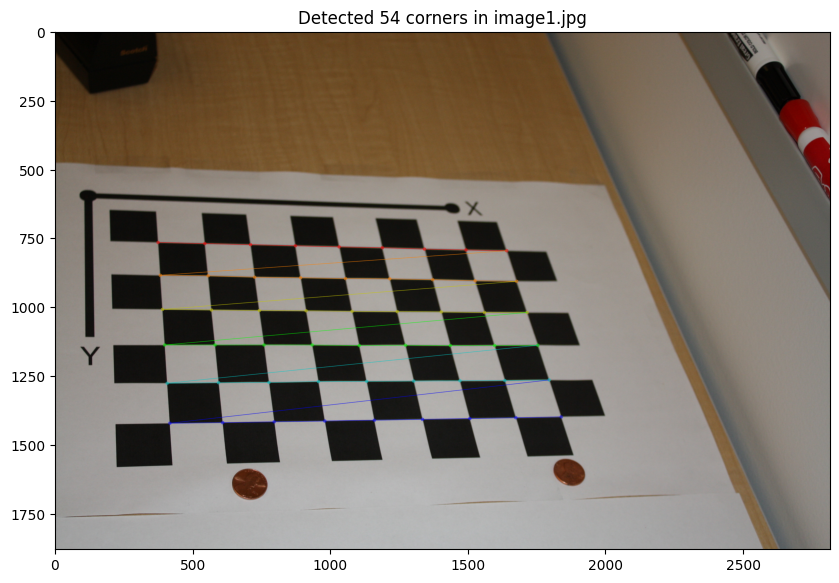

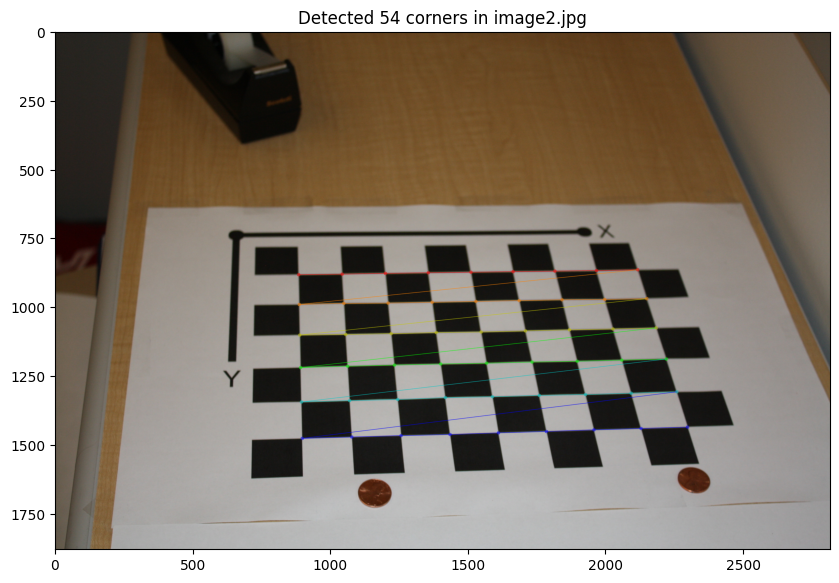

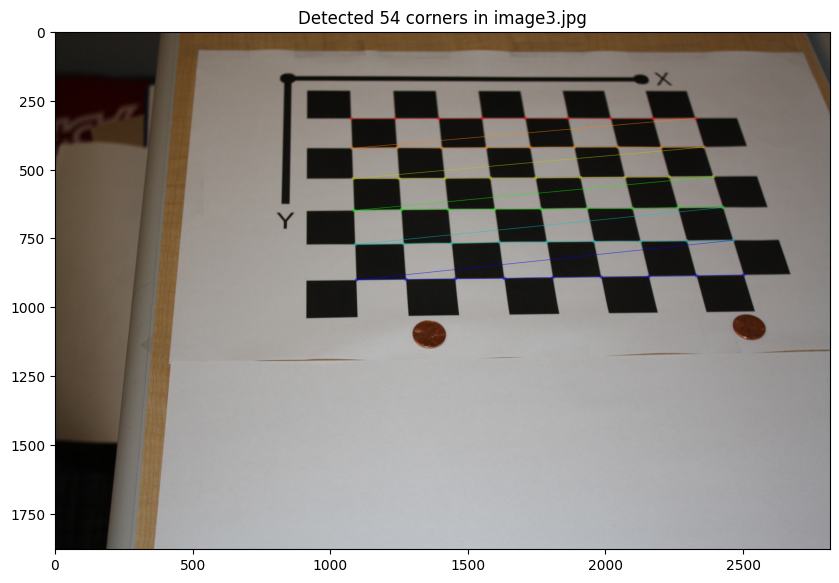

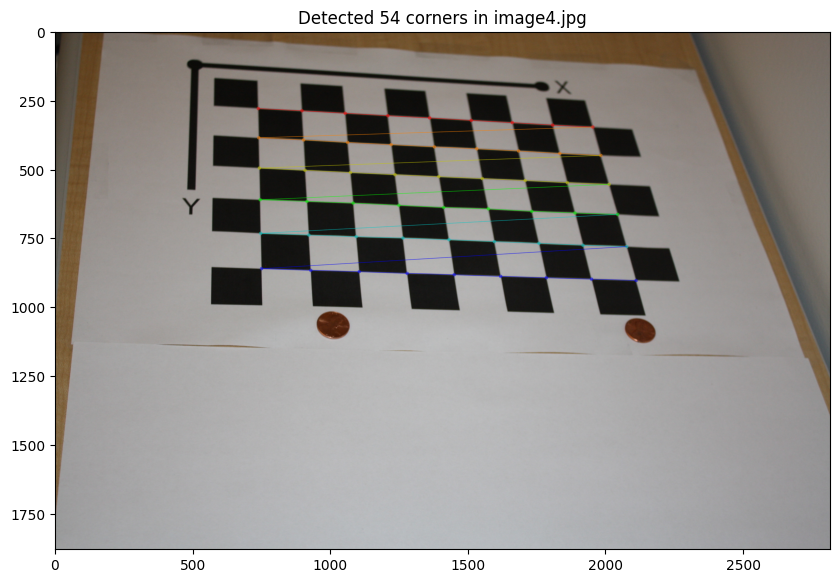

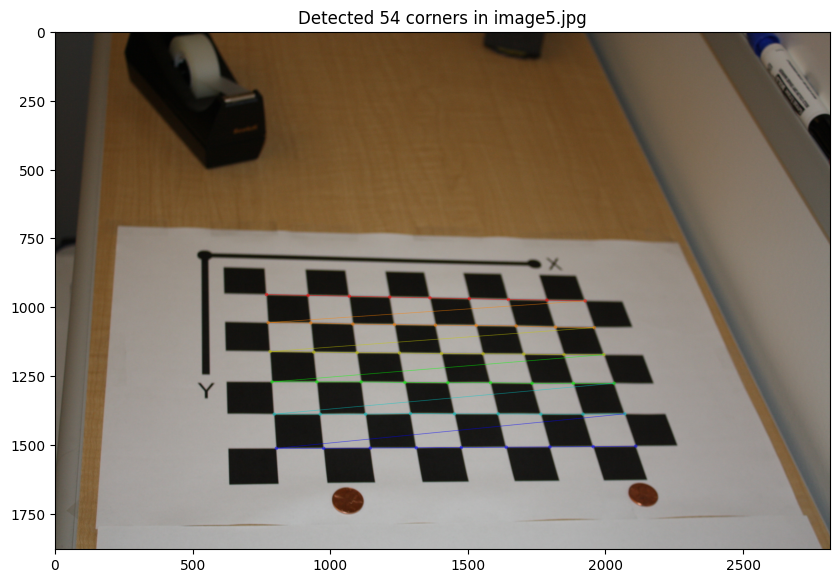

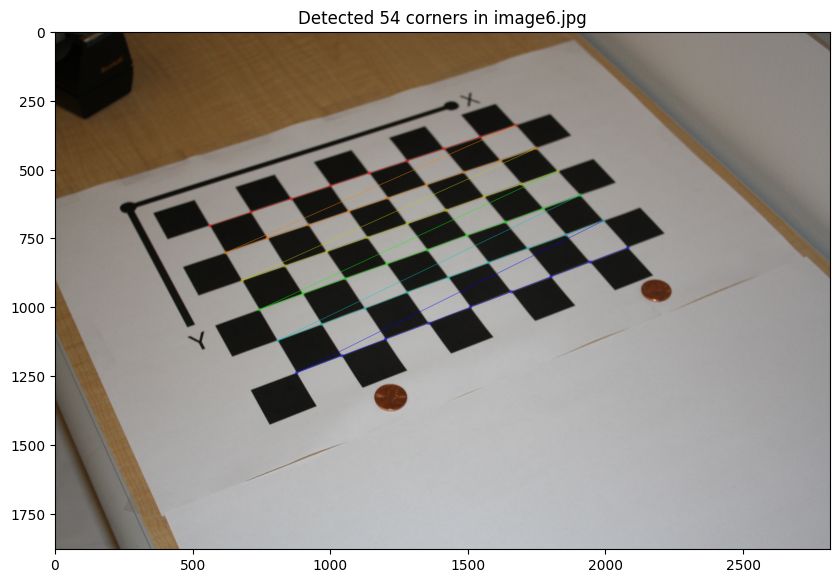

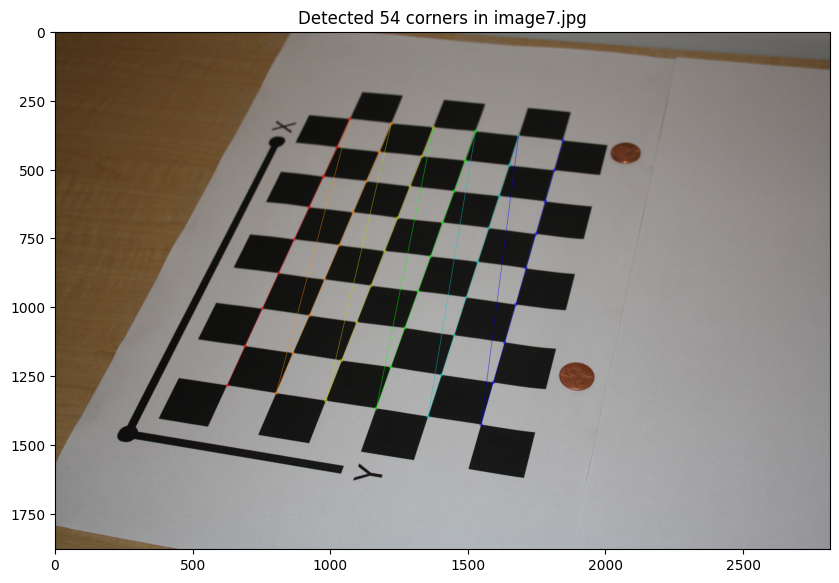

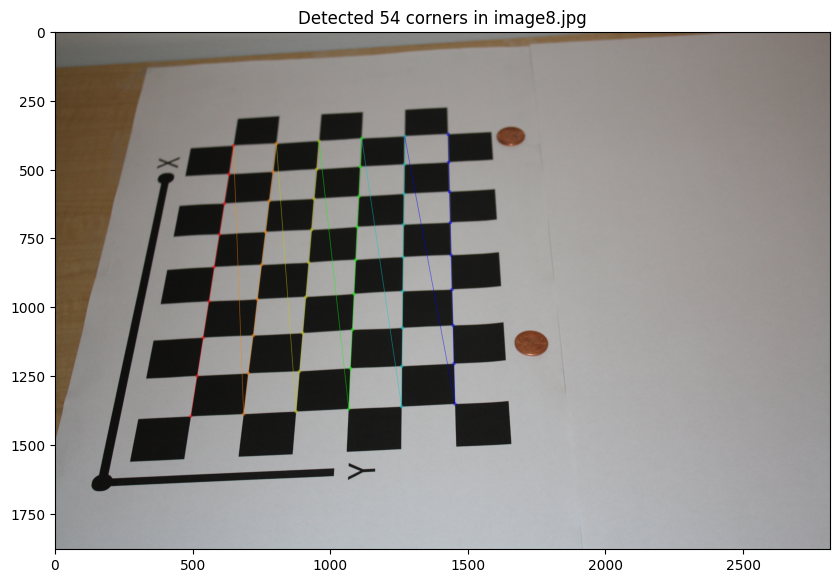

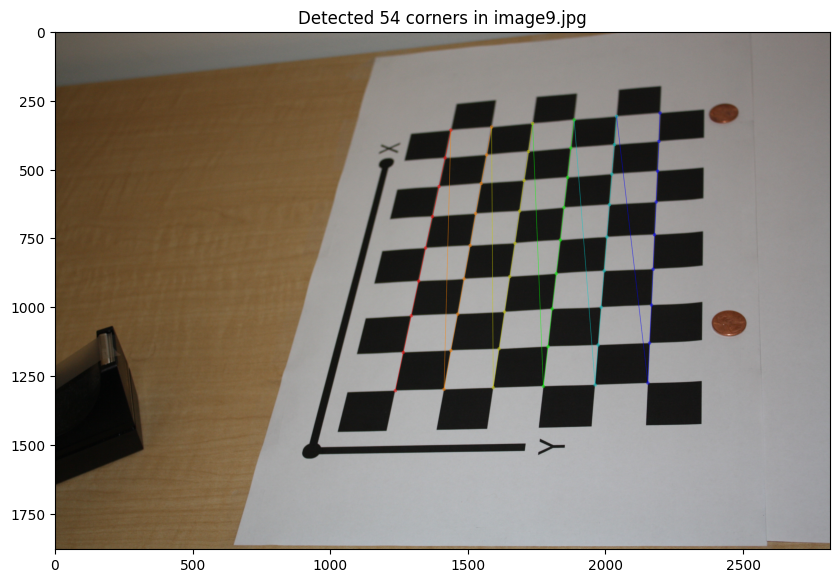

In [4]:
# Extracting path of individual image stored in a given directory
images = glob.glob('*.jpg')
images = sorted(images)

for cnt in range(len(images)):
    # Read image and store result in variable colorImg
    colorImg = cv.imread(images[cnt])
    # Convert image to grayscale & store result in variable grayImg
    grayImg = cv.cvtColor(colorImg,cv.COLOR_BGR2GRAY)
    #    
    """
    Find the chess board corners. If desired number of corners are found in the image then ret = true
    """
    retDetChkrBrd, corners = cv.findChessboardCorners(grayImg, (CHECKERBOARD_CORNER_NUM_X, CHECKERBOARD_CORNER_NUM_Y), cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_FAST_CHECK + cv.CALIB_CB_NORMALIZE_IMAGE )

    """
    Refine the pixel coordinates of detected corners and overlay them onto the images of checker board
    """
    if retDetChkrBrd == True:    
        # include the calibration grid points in the list wrldPts 
        wrldPts.append(calGridPts)
        #
        # refine pixel coordinates of checkerboard corners
        corners2 = cv.cornerSubPix(grayImg,corners,(11,11),(-1,-1),criteria) # DELIVERABLE
        # include the pixel coordinates of the calibration grid points in the list wlrdPts 
        imgPts.append(corners2)
        #
        # Draw and display the corners
        annotatedImg = cv.drawChessboardCorners(colorImg, CHECKERBOARD, corners2, retDetChkrBrd)
        #
        plt.figure(num=cnt, figsize=[10,10])
        plt.imshow( cv.cvtColor(annotatedImg, cv.COLOR_BGR2RGB) )
        strTitle = "Detected {} corners".format(np.product(CHECKERBOARD)) + " in {}".format(images[cnt])
        plt.title(strTitle)
        save_directory ='C:/Users/Hedieh/Documents/computer vision/Homework-6/results/'
        plt.savefig(save_directory + strTitle )

        plt.show()
    else:
        strTitle = "Uanble to detect {} corners".format(np.product(CHECKERBOARD)) + " in {}".format(images[cnt])
        plt.figure(num=cnt, figsize=[10,10])
        plt.imshow( grayImg, cmap='gray' )
        plt.title(strTitle)
        plt.savefig(save_directory + strTitle )
        plt.show()    
    """"""

#### <font color="yellow">Unit1: Calibrate the camera using the OpenCV function `calibrateCamera()`</font>
* Each calibration target is assumed to represent a regularly spaced grid of 3D points in the XY plane of the world coordinate system (WCS). 
* Attempt camera calibration by passing the value of the known 3D points (`wrldPts`) and observed pixel coordinates of the detected corners (`imgPts`) to the OpenCV function `calibrateCamera()`.
* The function build upon techniques discussed in Module-12 to solve for the <b>Camera Intrinsics</b> ($K$: focal length, principal point and Distortion parameters) & <b>Camera Extrinsics</b> (rotation matrix $R$, translation $[t_X,t_Y,t_Z]^T$).
<br>
<br>
* The output of the OpenCV function `calibrateCamera()` must be stored in the following variables: `retCamCal, K, distortion, Rvecs, Tvecs`
* Note that the intrinsic matrix $K$ is common to all images, whereas the extrinsics changes for each calibration image. 

In [6]:
if retDetChkrBrd == True:
    """
    Attempt camera calibration by passing the value of known 3D points (objpoints)
    and corresponding pixel coordinates of the detected corners (imgpoints)
    
    Mimic call to calibrateCamera() in https://opencv24-python-tutorials.readthedocs.io/en/stable/py_tutorials/py_calib3d/py_calibration/py_calibration.html
    """
    retCamCal, K, distortion, Rvecs, Tvecs = cv.calibrateCamera(wrldPts, imgPts, grayImg.shape[::-1], None, None) # DELIVERABLE 

    # All images in the list of calibration images share the same camera intrinsic parameters  
    print("Camera Intrinsic Matrix:\n{}\n".format(K))               # [fx 0 cx; 0 fy cy; 0 0 1]
    print("Distortion coefficients:\n{}\n".format(distortion))      # k1,k2,p1,p2,k3

    # To each image in the list of calibration images, there is an associated extrinsic parameter (rotation & translation)  
    for cnt in range(len(images)):
        print("\n" + images[cnt])
        
        strDisplay = "Translation Vector:{}".format( Tvecs[cnt].ravel() )
        print( strDisplay )               
        #
        rotvec = Rvecs[cnt].ravel() # unit vector
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.from_rotvec.html
        # eg: Reu = rot.from_rotvec(rotvec).as_euler('xyz', degrees=True)
        R = rot.from_rotvec(rotvec).as_matrix()
        strDisplay = "Rotation Matrix:\n{}\t".format( R )
        print( strDisplay ) 


Camera Intrinsic Matrix:
[[4.63510992e+03 0.00000000e+00 1.46278171e+03]
 [0.00000000e+00 4.61457230e+03 9.51145959e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion coefficients:
[[-1.27382529e-01  3.56181051e+00  1.34915035e-03  3.22293601e-03
  -3.46539960e+01]]


image1.jpg
Translation Vector:[-6.48252754 -1.09854184 27.48380101]
Rotation Matrix:
[[ 0.95342365  0.20184877 -0.22414376]
 [ 0.01308538  0.71471961  0.69928867]
 [ 0.3013505  -0.66965136  0.67878931]]	

image2.jpg
Translation Vector:[-3.65835536 -0.42366069 29.27923349]
Rotation Matrix:
[[ 0.9917323   0.10517574 -0.07351947]
 [-0.01610189  0.67038573  0.74183806]
 [ 0.12730977 -0.73452096  0.66653671]]	

image3.jpg
Translation Vector:[-2.42215983 -3.98083569 28.93645935]
Rotation Matrix:
[[ 0.99495324  0.07704262 -0.06428444]
 [-0.01424342  0.74262359  0.66955756]
 [ 0.09932361 -0.66526283  0.7399731 ]]	

image4.jpg
Translation Vector:[-4.5682636  -4.23867877 29.08832063]
Rotation Matrix:
[[ 0.97806313  0

#### <font color="yellow">Unit2: Digitally overlay XYZ axes onto each calibration target </font>
* Define world points (0,0,0), (5,0,0), (0,5,0), (0,0,5) corresponding to the origin of the world coordinate system (WCS) & points on the X,Y and Z axes respectively of the WCS 
* Identify their pixel projection using the OpenCV function `projectPoints()` for a specific choice of camera intrinsics & extrinsics
* Round to nearest integer and use the OpenCV function `arrowedLine()` to overlay the X,Y,Z axes of the WCS onto the calibration target. 

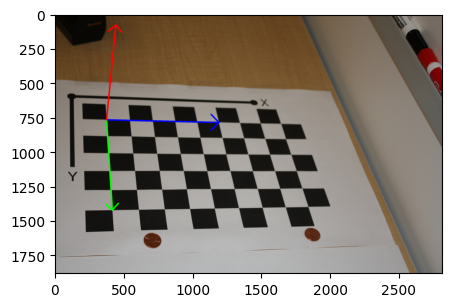

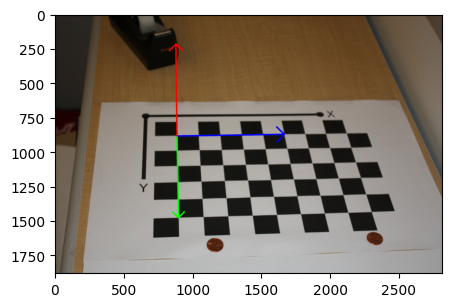

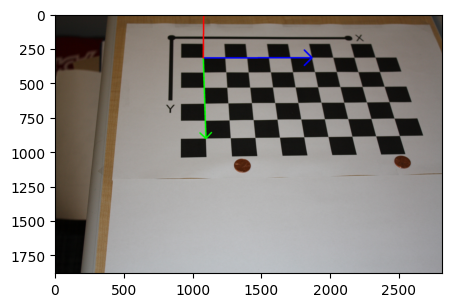

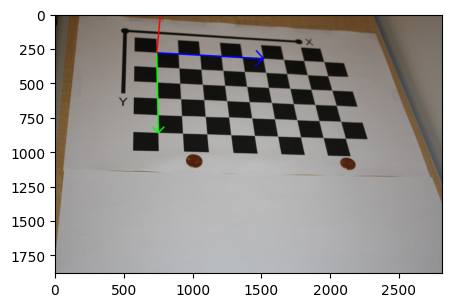

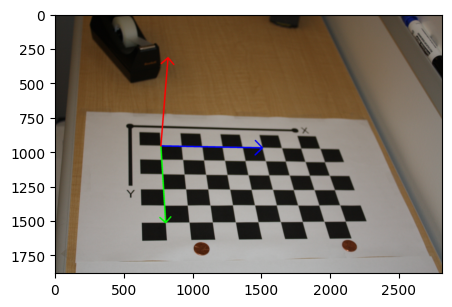

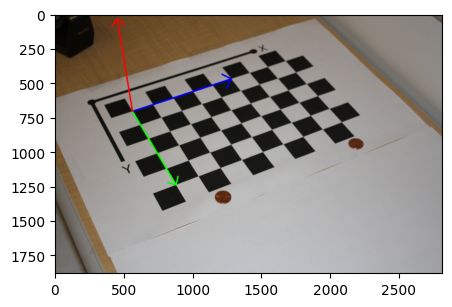

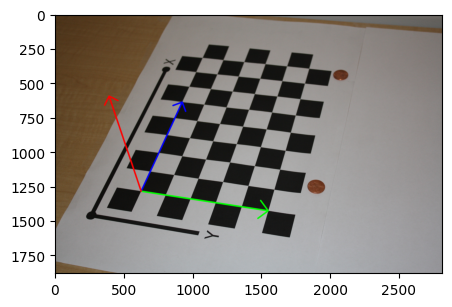

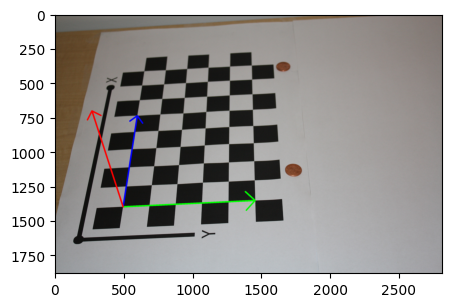

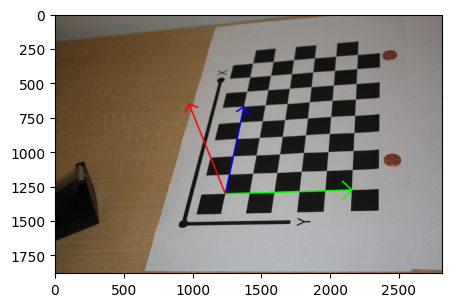

In [14]:
# Define world points
wrldPts = np.float32([[0,0,0], [5,0,0], [0,5,0], [0,0,-5]]).reshape(-1,3)

for cnt in range(len(images)):
    # Read image
    colorImg = cv.imread(images[cnt])
    
    """
    Project 3D world points onto image plane using call to projectPoints()
    Mimic call to projectPoints() in https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html#calibration
    """
    projectedPts, _ = cv.projectPoints(wrldPts, Rvecs[cnt], Tvecs[cnt], K, distortion)

    # Reshape projectedPts into matrix with ?? rows & 2 columns
    # The number of rows is automatically inferred since the first argument to reshape is set to -1
    projectedPts = projectedPts.reshape(-1, 2)
    projectedPts = np.int32(np.round(projectedPts)) # round to nearest integer so OpenCV can draw line
    
    # X axis - blue
    annotatedImg = cv.arrowedLine(colorImg, projectedPts[0,:], projectedPts[1,:], (255,0,0), 10)
    # Y axis - green
    annotatedImg = cv.arrowedLine(colorImg, projectedPts[0,:], projectedPts[2,:], (0,255,0), 10)
    # Z axis - red
    annotatedImg = cv.arrowedLine(colorImg, projectedPts[0,:], projectedPts[3,:], (0,0,255), 10)

    plt.figure(num=cnt, figsize=[5,5])
    plt.imshow( cv.cvtColor(annotatedImg, cv.COLOR_BGR2RGB) )
    plt.savefig(save_directory + "annotatedImg"+str(cnt)+".jpg" )
    plt.show()

#### <font color="yellow">Uint3: Overlay teapot onto last calibration target </font>
Please refer to homework instructions fro help with this unit 



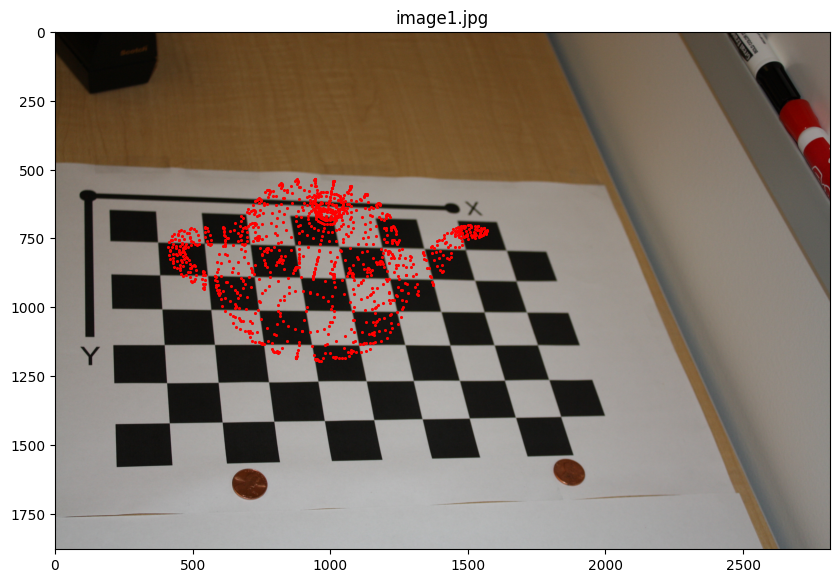

In [13]:
# Load mesh, together with setting the flag for post-processing to True, so the texture and material will be loaded
# Define numpy array to store 3D point-cloud representation of teapot
mesh_path = './teapot.ply'
mesh = o3d.io.read_triangle_mesh(mesh_path,True)
# Define numpy array to store 3D point-cloud representation of teapot
wrldPts = np.asarray(mesh.vertices)
wrldPts[:,0] = (wrldPts[:,0] - min(wrldPts[:,0]))       # Xw coordinate >= 0
wrldPts[:,1] = (wrldPts[:,1] - min(wrldPts[:,1]))       # Yw coordinate >=0     
wrldPts[:,2] = -(wrldPts[:,2] - min(wrldPts[:,2]))      # Flip Zw coordinate


# Read specific image
cnt = 0     # 0 for image1.jpg, change for other images
colorImg = cv.imread(images[cnt])

# project 3D points to image plane
projectedPts, _ = cv.projectPoints(wrldPts, Rvecs[cnt], Tvecs[cnt], K, distortion)
projectedPts = projectedPts.reshape(-1, 2) 
# Extract the x & y pixel coordinates from projectedPts
# Reshape projectedPts into matrix with ?? rows & 2 columns
# The number of rows is automatically inferred since the first argument to reshape is set to -1
pt_x = projectedPts[:, 0]
pt_y = projectedPts[:, 1]

plt.figure(figsize=[10,10])
# Display image
plt.imshow( cv.cvtColor(colorImg, cv.COLOR_BGR2RGB) )
# Plot (pt_x,pt_y)
plt.plot(pt_x,pt_y,'r.',markersize=2.5)
plt.title("{}".format(images[cnt]))
plt.savefig(save_directory + "teapot.jpg" )